# Анализ приложения для доставки 

Команда разработки приложения разработала новую умную систему рекомендации товаров, которая позволяет пользователям эффективнее работать с приложением и лучше находить необходимые товары. Для того, чтобы проверить эффективность новой системы приложений был проведен AB-тест, в котором пользователей разделили на контрольную (0) и тестовую (1) группы. Пользователи в контрольной группе пользовались старой версией приложения, а пользователи в тестовой группе - новой 

#### Правда ли что новая система рекомендаций улучшила качество сервиса?

Давайте узнаем!

## Подключение к данным

In [1]:
# импорт необходимых библиотек 

import re
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from scipy import stats
from urllib import parse
from statsmodels.stats.power import TTestIndPower

%matplotlib inline

In [2]:
# параметры визуализации
sns.set(
    rc = {
        'figure.figsize'  : (17, 8),
        'axes.titlesize'  : 16,
        'axes.labelsize'  : 14,
        'xtick.labelsize' : 12,
        'ytick.labelsize' : 12
    }
)

In [3]:
# вспомогательная функция 1

def draw_histplot(samples: list, suptitle: str):
    """
    Функция рисует гистограммы распределения для 2-х выборок 
    
    Параметры
    ---------
    samples:
        Контрольная и тестовая выборки
    suptitle:
        Общее название визуализации
    """
    
    figure, axes =  plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
    colors       = ['mediumpurple', 'forestgreen']
    titles       = ['control', 'test']
    
    for ax, sample, color, title in zip(axes.flatten(), samples, colors, titles):
        sns.histplot(sample, color = color, ax = ax, bins = 10)
        ax.set_title(title)
        ax.grid(True, color='#e2e2e2', alpha=0.5)
        
    figure.suptitle(suptitle)
    
    plt.show()
    
# вспомогательная функция 2
    
def show_statistics (sample):
    """
    Функция возвращает описательные статистики (среднее, медиану и std) для выборки
    
    Параметры
    ---------
    sample:
        Выборка
        
    Возвращаемое значение
    ---------------------
        Словарь со средним, медианой и стандартным отклонением
    """
    return {
        'mean'     : sample.mean(),
        'median'   : sample.median(),
        'std'      : sample.std(),
        'skew'     : sample.skew(),
        'kurtosis' : sample.kurtosis()
    }

# вспомогательная функция 3

def calc_pooled_var (control_var: float, test_var: float, nobs1: int, nobs2: int) -> float:
    """
    Функция возвращает общую дисперсию для расчета стандартизированного размера эффекта
    
    Параметры:
    ---------
    control_var:
        Дисперсия данных в контрольной группе
    test_var:
        Дисперсия данных в тестовой группе
    nobs1:
        Размер контрольной группы
    nobs2:
        Размер тестовой группы 
    
    Возвращаемое значение:
    ----------------------
        Общая дисперсия двух выборок
    """
    return np.sqrt((((nobs1 - 1) * control_var) + ((nobs2 - 1) * test_var))/(nobs1 + nobs2 - 2))

In [53]:
# функция для проведение дельта-метода 

def check_delta_method(control, test):
    """
    Функция для проведения дельта-метода для сравнения средних ratio-метрик
    
    Параметры:
    ---------
    control:
        Данные контрольной выборки (выборки без изменений)
    test:
        Данные тестовой выборки (выборки с изменениями)
        
    Возвращаемое значение:
        p_value
    """
    
    info = {}
    
    for data, name in [(control, 'control'), (test, 'test')]:
        
        # собираем данные для оценки дисперсии 
        number_of_objects         = data.user_id.nunique()
        prices                    = data.groupby('user_id', as_index=False).agg({'price':'sum'}).price
        quantities                = data.groupby('user_id', as_index=False).agg({'order_id':'count'}).order_id
        mean_price, mean_quantity = prices.mean(), quantities.mean()
        var_price, var_quantity   = np.var(prices), np.var(quantities)
        cov_price_quantity        = np.cov(prices, quantities)[0, 1]
        
        # точечно оцениваем ratio-метрику
        pe_metric = np.sum(prices) / np.sum(quantities)
       
        # оцениваем дисперсию данной метрики 
        var_metric = (
            var_price / mean_quantity ** 2
            - 2 * (mean_price / mean_quantity ** 3) * cov_price_quantity
            + (mean_price ** 2 / mean_quantity ** 4) * var_quantity
        ) / number_of_objects        
        
        # добавляем параметры в словарь
        
        info['{}_pe_metric'.format(name)] = pe_metric
        info['{}_var_metric'.format(name)] = var_metric
        
    # проверяем статистическую значимость различий в значениях ratio-метрик
    common_var = info['control_var_metric'] + info['test_var_metric']
    difference = info['test_pe_metric'] - info['control_pe_metric']
    
    t          = difference / np.sqrt(common_var)
    p_value    = (1 - stats.norm.cdf(np.abs(t))) * 2
    
    return p_value

In [4]:
# формирование ссылок для подключения к данным через Яндекс Диск API

base_url   = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_keys = {
    'users_data'  : parse.urlencode(dict(public_key='https://disk.yandex.ru/d/4qY27tJ23G_B1g')), # данные о пользователях
    'orders_data' : parse.urlencode(dict(public_key='https://disk.yandex.ru/d/prdO8FDQx7lzCg')), # данные о заказах
    'items_data'  : parse.urlencode(dict(public_key='https://disk.yandex.ru/d/atwrlmB_wu-fHA'))  # данные о товарах
}

final_urls = {
    'users_data_url'  : base_url + public_keys['users_data'],
    'orders_data_url' : base_url + public_keys['orders_data'],
    'items_data_url'  : base_url + public_keys['items_data']
}

Здесь мы подключаемся к данным. Могли бы сделать это в разных ячейках и, если на какой-нибудь ссылке подключение упало, то остальные данные могли бы скачаться. Но (!), нам нужны все данные для анализа, поэтому не имеет смысла загружать их по частям

In [51]:
# получение ссылок на скачивание данных через Яндекс Диск API

try:
    load_urls = {
        'users_url'  : requests.get(final_urls['users_data_url']).json()['href'],
        'orders_url' : requests.get(final_urls['orders_data_url']).json()['href'],
        'items_url'  : requests.get(final_urls['items_data_url']).json()['href']
    }
except:
    print('Какой-то файл не смог скачаться :)')

In [6]:
# загружаем данные о пользователях (заранее парсим даты)

users_data = pd.read_csv(load_urls['users_url'], parse_dates = ['time', 'date'])

In [7]:
# загружаем данные о заказах

orders_data = pd.read_csv(load_urls['orders_url'], parse_dates = ['creation_time'])

# раскрываем список с товарами в заказах

orders_data['product_ids'] = orders_data.product_ids.apply(lambda x: re.sub('[{,}]', '', x).split(' ')) 
orders_data = orders_data.explode('product_ids').rename(columns = {'product_ids' : 'product_id'}).astype({'product_id':'int64'})

In [8]:
# загружаем данные о товарах

items_data = pd.read_csv(load_urls['items_url'])

### Предварительный анализ данных

Перед основной работой с данными их необходимо "разведочно" посмотреть, чтобы сформировать первое представление о том, с каким вообще данными мы имеем дело.

#### Данные о пользователях

- Количество строк: **4337**
- Количество столбцов: **6**

| Название столбца         |  Что значит | Тип данных | Уникальность в таблице| Количество в дата-фрейме| NULL-значения|
|:------------- |:---------------| :-------------:| :--:| :--:|:--: |
| user_id          | идентификатор пользователя          | Int64       | Нет| 1017 | Нет|
| order_id         | идентификатор заказа         | Int64       |Нет | 4123|Нет|
| action         | действие пользователя          | String       | Нет|2 |Нет|
| time         | время действия          | Datetime64        | Нет|4312 |Нет|
| date        | дата действия          | Datetime64        | Нет| 14|Нет|
| group       | группа          | Int64        | Нет| 2|Нет|

#### Данные о заказах

- Количество строк: **4123**
- Количество столбцов: **3**

| Название столбца         |  Что значит | Тип данных | Уникальность в таблице| Количество в дата-фрейме| NULL-значения|
|:------------- |:---------------| :-------------:| :--:| :--:|:--: |
| order_id         | идентификатор заказа         | Int64       |Да | 4123|Нет|
| сreation_time         | создание заказа          | Datetime64       | Нет|4098 |Нет|
| product_ids       | идентификаторы товаров в заказа          | Object (list)        | Нет| 3877|Нет|

#### Данные о товарах

- Количество строк: **87**
- Количество столбцов: **3**

| Название столбца         |  Что значит | Тип данных | Уникальность в таблице| Количество в дата-фрейме| NULL-значения|
|:------------- |:---------------| :-------------:| :--:| :--:|:--: |
| product_id         | идентификатор товара         | Int64       |Да | 87|Нет|
| name        | имя товара          | String       | Да|87 |Нет|
| price       | цена товара          | Float64        | Нет| 63|Нет|


Видно, что данные собраны нормально и, кажется, что не было ошибок в алгоритме сбора данных, так как соблюдаются (по смыслу) уникальные значения, отсутствуют NULL-значение и типы данных также на местах. Также можем сказать, что размеры выборки приблизительно по **500 человек**

## Интерпретация результатов

Попробуем поразмыслить в сторону метрик в рамках монетизации. Улучшением качества сервиса для пользователя может считаться нахождение неоходимого ему товара, что в свою очередь принесет прибыль нашему продукту - это win-win. С одной стороны, чем больше покупок сделает пользователь, тем больше прибыли сможет получить продукт, но есть одно большое НО! Если наша рекомендательная система работает таким образом, что предлагает пользователю необходимые ему товары, но в несколько раз дешевле, то даже не смотря на увеличение количества покупок пользователями, прибыль для продукта не будет увеличиваться (если вообще не уменьшиться).

Нужно чтобы было данная система удовлетворяла потребностям и пользователя и продукта. Это можно устроить - если пользователь делает больше покупок и при этом стоимость его покупок не падает. Получается, что чем больше покупок, тем больше прибыль продукту. Все просто!

Соответственно, метриками в рамках монетизации нашей платформы могут выступать:

- Количество покупок, сделанные пользователем 
- Средний чек пользователя
- Прибыль с пользователя 

Таким образом, нужно проверить, что у нас **при увеличении количества покупок, увеличивается или остается неизменным средний чек пользователя. Все это ведет к увеличению прибыли. Profit!**


<img src = "https://assets-global.website-files.com/61bcbae3ae2e8e0565a790d1/62144c21b255406deefa0cff_image2.png">

### Достоверность результатов 

Очень важная вещь! Обычно, перед проведением AB-тестов заранее определяется размер выборки (от него зависит, как долго будет идти тест). Он определяется для определенных параметров:

- Уровень значимости 1 - alpha: вероятность не найти различия там, где их нет
- Мощность эксперимента 1 - beta: вероятность найти различия там, где они есть
- MDE - минимальный истинный эффект, который можно будет обнаружить с определенной мощностью эксперимента для определенного уровня статистической значимости

Так как у нас на руках уже финальные результаты, мы знаем размер выборки, мощность теста (стандартный) и уровень значимости (стандартный). Соотвественно, имея эти вводные мы можем рассчитать минимальный истинный эффект, который можно будет обнаружить с помощью критерия Стъюдента при таких параметрах alpha, beta и размере выборки

In [9]:
# расчет MDE

power_analysis = TTestIndPower()
nobs1          = users_data.loc[users_data.group == 0].user_id.nunique()
nobs2          = users_data.loc[users_data.group == 1].user_id.nunique()
ratio          = nobs2 / nobs1
mde            = power_analysis.solve_power(nobs1=nobs1, alpha=0.05, power=0.8, ratio=ratio)

print('Минимальный детектируемый эффект для данных параметров: {}'.format(round(mde, 2)))

Минимальный детектируемый эффект для данных параметров: 0.18


При используемых в нашем случае данных, минимальный истинный эффект, который мы можем обнаружить c вероятностью 80% с такими параметрами alpha, beta и размер выборки n, равняется = **0.175**. Согласно приведенной ниже таблице - эффект довольно-таки слабый

<img src = "https://www.researchgate.net/publication/344626794/figure/tbl2/AS:946094485815298@1602577911175/Cohens-Effect-Size-Ranges-and-Their-Meanings.png">


## 1. Количество покупок на пользователя

Для начала посмотрим, как новая система рекомендаций влияет на количество покупок на пользователя. В качестве покупки будет считать заказ без статусa "cancel_order". Предварительно нужно подготовить данные

In [10]:
# количество заказов на пользователя

purchases_per_user_data = users_data \
    .pivot_table(values='order_id', index=['user_id', 'group'], columns='action', aggfunc = 'count',fill_value = 0) \
    .reset_index() 

purchases_per_user_data['purchases'] = purchases_per_user_data.create_order - purchases_per_user_data.cancel_order

In [11]:
# подготовка выборок 

control_purchases = purchases_per_user_data.loc[purchases_per_user_data.group == 0].purchases
test_purchases    = purchases_per_user_data.loc[purchases_per_user_data.group == 1].purchases

Для дальнейшего анализа нам необходимо понять, какой статистический критерий для сравнения среднего мы будем использовать. У нас есть варианты в виде параметрического или непараметрического. Использование параметрического критерия предполагает соблюдение определенных условий:

- Нормальное распределение данных
- Отсутствие выбросов 
- Гомогенность дисперсии

Проверим, соответствуют ли наши данные перечисленным условиям. Для начала проверим нормальность распределения сразу несколькими способами

#### 1.1 Гистограммы распределения

Для начала посмотрим гистограммы распределния выборочных данных, чтобы понять, как вообще распределены данные. Это позволит сделать нам первое предположение о распределении 

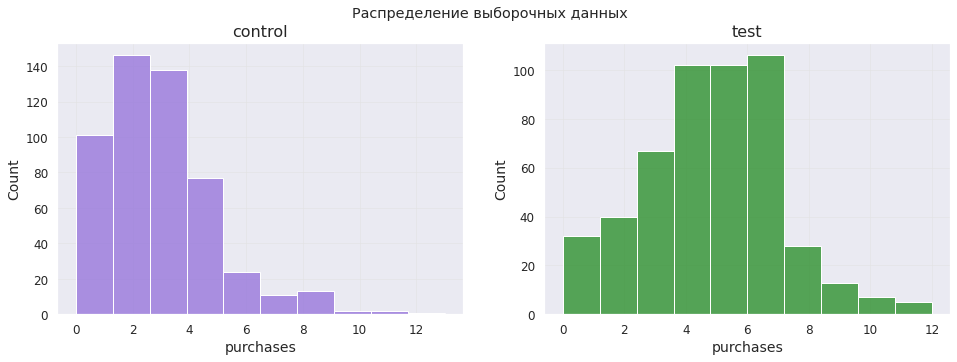

In [12]:
# построение гистограмм распределения

draw_histplot([control_purchases, test_purchases], 'Распределение выборочных данных')

#### 1.2 Описательные статистики 
Также попробуем сравнить средние значения по выборкам с медианами, чтобы узнать насколько сильно отличаются друг от друга. В нормальном распределения средние значения и медианные должны не сильно отличаться друг от друга, смещение = 0, а эксцесс = 3

In [13]:
# описательные статистики для контрольной выборки 

show_statistics(control_purchases)

{'mean': 2.9650485436893206,
 'median': 3.0,
 'std': 1.8947864543941773,
 'skew': 1.659348054500398,
 'kurtosis': 3.6748153264875594}

In [14]:
# описательные статистики для тестовой выборки 

show_statistics(test_purchases)

{'mean': 4.745019920318725,
 'median': 5.0,
 'std': 2.1469760332678938,
 'skew': 0.44282552488067817,
 'kurtosis': 0.19439546094123994}

После того, как мы нашли наши средние по группам **можно посчитать uplift - насколько у нас изменилась метрика в тестовой группе относительно контрольной группы**, а затем посчитать размер эффекта. В данном случае **effect size будет лучше отображать отличие тестовой группы от контрольной, так как будет учитывать выборочные дисперсии и размер выборок**

#### 1.3 Uplift

In [15]:
# расчет прироста тестовой метрики относительно контрольной 

uplift = (test_purchases.mean() / control_purchases.mean()) - 1
print('Uplift составил {}%'.format(round(uplift * 100, 2)))

Uplift составил 60.03%


#### 1.4 Effect Size

In [16]:
# расчет полученного размера эффекта

# дисперсии данных в контрольной и тестовой группах
control_var = control_purchases.var()
test_var    = test_purchases.var()

# общая дисперсия
pooled_var  = calc_pooled_var(control_var, test_var, nobs1, nobs2)

# размер эффекта
effect_size = (test_purchases.mean() - control_purchases.mean()) / pooled_var

print('Стандартизированный размер эффекта, выявленный в результате эксперимента: {}'.format(round(effect_size, 2)))

Стандартизированный размер эффекта, выявленный в результате эксперимента: 0.88


В результате эксперимента мы получили, что размер эффекта, полученный в результате внедрения новой рекомендательной системы, для такой метрики, как количество покупок на пользователя, составляет 0.88. В данном случае он показывает **степень отклонения наблюдаемых значений метрики от тех, которые можно было бы ожидать при отсуствии эффекта.**

Согласно шкале интерпретации эффекта Коэна - это довольно-таки большой эффект. Сравнивая его с MDE (0.175) можем заключить, что вероятность обнаружения такого эфффекта довольно-таки высокая, а значит мы можем доверять результатам нашего AB-тестирования

На основании полученных гистограмм и описательных статистик можно сказать, что распределения не выглядят нормальными **Видно, что полученное различие между средними вполне детектируется с 80% вероятностью при нашем размере выборке и уровне значимости**

Попробуем применить более профессиональные статистические критерии, чтобы проверить гипотезу о том, что данные выборки принадлежат ГС с нормальными распределениями
#### 1.5 Статистические критерии

- Шапиро-Уилка (для выборок < 1000)
- Харке-Бера
- Д'агостино (Normal Test)

Для проверки выберем какой-нибудь один. В данном случае будем использовать метод Шапиро-Уилка, так как он наиболее мощный их всех

In [17]:
# проверка на нормальность критерием Шапиро-Уилка
shapiro = {
    'control_p' : stats.shapiro(control_purchases)[1],
    'test_p'    : stats.shapiro(test_purchases)[1]
}

print('Контрольное распределение: {}'.format('ненормальное' if shapiro['control_p'] < 0.05 else 'нормальное'))
print('Тестовое распределение: {}'.format('ненормальное' if shapiro['test_p'] < 0.05 else 'нормальное'))

Контрольное распределение: ненормальное
Тестовое распределение: ненормальное


Наши статистические критерии подтвердили, что выборочные данные в обеих группах не распределены нормально. Из этого следует, что у нас есть несколько вариантов: 

- Использовать непараметрический тест Манна-Уитни 
- Преобразовать данные логарифмированием или преобразованием Бокса-Кокса и провести T-Test
- Использовать T-Test в любом случае, так как размер нашей выборки > 100 и позволяет нам так делать (да и вообще для t-теста распределение выборочных данных не обязательно должно быть нормальным)

Попробуем использовать 2 варианта: U-тест Манна-Уитни и T-критерий Стъюдента. Однако, чтобы использовать Стъюдента необходимо понять, одинаковая ли изменчивость в 2-х выборках или нет. Для этого будем использовать тест Левена, так как он более робастный к ненормальным распределениям, чем условный тест Бартлетта

In [18]:
# проверка на гомоскедастичность тестом Левена

stats.levene(control_purchases, test_purchases)

LeveneResult(statistic=16.84374227950037, pvalue=4.3843490662180984e-05)

Тест Левена показал, что у нас достаточно оснований отклонить нулевую гипотезу о равенстве дисперсий в 2-х выборках, а это значит, что, если мы будем использовать T-Test, то нужно брать модификацию Уэлча для данного теста. Сперва проверим гипотезу о равенстве 2-х средних значений покупок на пользователя с помощью T-теста Уэлча

#### 1.6 Проверка гипотезы о равенстве количества покупок в 2-х группах

- T-Test Уэлча
- U-критерий Манна-Уитни (используется на выборках от 3 до 60, однако все-равно попробуем)

In [19]:
# тест Уэлча для выборок с неоднородными дисперсиями

stats.ttest_ind(control_purchases, test_purchases, equal_var = False)

Ttest_indResult(statistic=-14.004857145357283, pvalue=8.436864886644697e-41)

In [20]:
# критерий Манна-Уитни 

stats.mannwhitneyu(control_purchases, test_purchases)

MannwhitneyuResult(statistic=63507.0, pvalue=8.932329495353261e-46)

Результаты обеих статистических проверок говорят о том, что имеются все основания отклонить нулевую гипотезу о равенстве среднего количества покупок в 2-х группах, и что различия между ними статистически значимы. Из этого следует, что **в группе с новой системой рекомендации товаров среднее количество покупок, совершаемых пользователем выше, чем в группе со старым алгоритмом**. 

Теперь проверим, траты пользователей, так как количество покупок может вырасти, но покупаемые товары станут дешевле. Например, пользователь мог раньше покупать 1 товар по 300 рублей, а теперь покупает 2 товара по 150 рублей или 3 товара за 100 рублей - в таком случае количество покупок выросло, но средний чек пользователя стал меньше. Для нашей компании это может быть невыгодно, так как теперь наши курьеры больше загружены (расходы могут стать больше), но прибыли с этого больше не стало. Поэтому нужно выяснить, как изменились средний чек для наших пользователей 

## 2. Средний чек пользователя

Для того, чтобы посмотреть средние траты пользователя необходимо сначала подготовить данные. Для этого нужно объединить данные по пользователям и данные по заказам и товарам, рассчитать нужный показатель для пользователя, а после разбить данные на группы (разбивка последним шагом, чтобы не делать расчет 2 раза)

Для проверки гипотезы о равенстве так называемых ratio-метрик (метрик отношения) будем использовать дельта-метод, так как обычные методы типа теста Стъюдента для проверки средних не сработают из-за зависимости данных, а дельта-метод учитывает д **Покупки одного пользователи с большой вероятностью будут зависимыми данными, в то время вероятность того, что покупки разных пользователей никак не влияют друг на друга**

В данном случае можно было бы также использовать бутстрэп, однако данный метод слишком затратен с точки зрения ресурсов. Проведение дельта-метода будем проводить согласно следующей формулы оценки дисперсии ratio-метрики:

<img src = "https://habrastorage.org/r/w1560/getpro/habr/upload_files/164/709/8b8/1647098b8e9ffb14c5c250cb0c376d89.png" alt = "Формула для оценки дисперсии ratio-метрики">

После того, как найдем дисперсию ratio-метрики при помощи указанной выше формулы, рассчитаем t-критерий по следующей формуле:

<img src = "https://habrastorage.org/getpro/habr/upload_files/a05/378/c91/a05378c91eee426dbde1453c438a0c21.svg" alt = "Формула расчета t-критерия Стъюдента с дисперсией для зависимых данных">

In [21]:
# объединение данных по заказам с данными по товарам

total_orders_data = orders_data.merge(items_data, how = 'left', on = 'product_id')

In [22]:
# объединение данных по пользователям с данными по заказам

data = users_data.merge(total_orders_data, how = 'left', on = 'order_id')

In [52]:
# формирование выборок 

control_aov = data.loc[data.group == 0].groupby(['user_id', 'order_id'], as_index=False).agg({'price':'sum'})
test_aov = data.loc[data.group == 1].groupby(['user_id', 'order_id'], as_index=False).agg({'price':'sum'})

In [55]:
# расчет p_value дельта-методом 

check_delta_method(control_aov, test_aov)

0.25240897623635994

In [25]:
# расчет пользовательских трат

aov_data = data \
    .pivot_table(
        values     = 'price',
        index      = ['user_id', 'order_id', 'group'],
        columns    = 'action',
        aggfunc    = 'sum',
        fill_value = 0
    ) \
    .reset_index()

aov_data = aov_data \
    .assign(order_value = aov_data.create_order - aov_data.cancel_order) \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'order_value' : 'mean'}) \
    .rename(columns = {'order_value' : 'aov'})

In [26]:
# формирование выборок

control_aov = aov_data.loc[aov_data.group == 0].aov
test_aov    = aov_data.loc[aov_data.group == 1].aov

Для того, чтобы проверить есть ли статистически значимое различие между 2-мя показателями, необходимо повторить тот же алгоритм, что и при проверке различий количестве покупок

#### 2.1 Гистограммы распределения

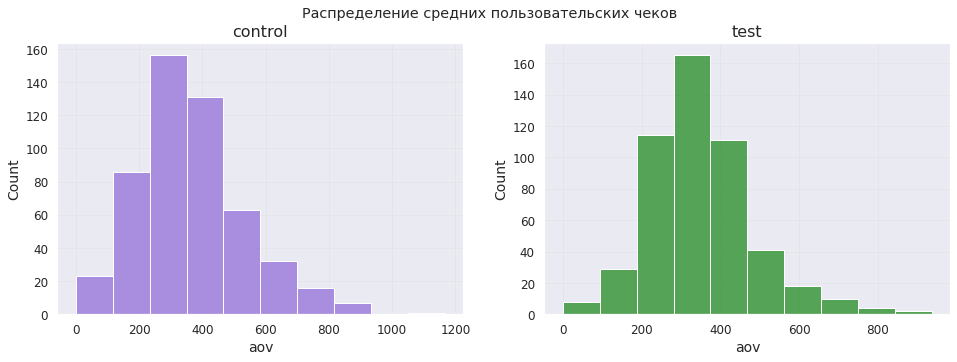

In [27]:
# построение гистограмм распределения

draw_histplot([control_aov, test_aov], 'Распределение средних пользовательских чеков')

#### 2.2 Описательные статистики

In [28]:
# описательные статистики для контрольной выборки 

show_statistics(control_aov)

{'mean': 364.2505970550485,
 'median': 343.70000000000005,
 'std': 166.79103068937934,
 'skew': 0.7567487342001927,
 'kurtosis': 1.1348750366462408}

In [29]:
# описательные статистики для тестовой выборки 

show_statistics(test_aov)

{'mean': 352.3455473637695,
 'median': 340.40250000000003,
 'std': 132.89487164342805,
 'skew': 0.8733720404257034,
 'kurtosis': 1.8253778653091506}

После того, как мы выяснили средние значения метрик, необходимо, как и в случае с предыдущими метриками, выяснить получившийся размер эффекта для среднего чека в друх группах и сравнить его с минимальным истинным эффектом, чтобы понять, можем ли мы вообще доверять результатам дальнейшего сравнения при используемых параметрах alpha, beta и размер выборки n. 

#### 2.3 Lift

In [30]:
# расчет изменения среднего чека в тестовой группе относительно метрики в контрольной
lift = (test_aov.mean() / control_aov.mean()) - 1
print('Lift составил {}%'.format(round(lift * 100, 2)))

Lift составил -3.27%


#### 2.4 Effect Size

In [31]:
# расчет полученного размера эффекта

# выборочные дисперсии данных в тестовой и контрольной группе
control_var = control_aov.var()
test_var    = test_aov.var()

# расчет общей дисперсии в 2-х группах
pooled_var  = calc_pooled_var(control_var, test_var, nobs1, nobs2)

# effect size
effect_size = (test_aov.mean() - control_aov.mean()) / pooled_var
print('Стандартизированный размер эффекта, выявленный в результате эксперимента: {}'.format(round(effect_size, 2)))

Стандартизированный размер эффекта, выявленный в результате эксперимента: -0.08


В данном случае, полученный размер эффекта меньше, чем MDE (0.175). Это говорит о том, что для того, чтобы зафикировать полученный эффект с большой вероятностью (не совершить ошибку II рода), нам нужно поменять параметры проведения исследования (например, увеличить размер выборки

Давайте проверим, выборку какого размера надо было брать, чтобы с большой долей вероятности - 80% - зафиксировать отклонение тестовой метрики от контрольной. 

In [32]:
# необходимая выборка для достоверной фиксации эффекта в 0.08
sample_size = power_analysis.solve_power(effect_size=0.08, power=0.8, alpha=0.05)

# текущая мощность при MDE = 0.08
power       = power_analysis.solve_power(nobs1=nobs1, alpha=0.05, effect_size = 0.08, ratio=ratio)

print('Необходимая выборка: {}'.format(int(sample_size)))
print('Текущая мощность: {}%'.format(round(power * 100, 2)))

Необходимая выборка: 2453
Текущая мощность: 24.71%


Для того, чтобы с большой вероятность доверять полученным результатам, выборка для MDE, равного 0.08, должна составлять 2453 пользователя. В нашем случае, **вероятность найти различия в средних чеках, если они действительно есть, составляет порядка 25% (маловато)**

Исходя из результатов полученных гистограмм и описательных статистик, можно сказать, что на первый взгляд распределение данных не является нормальным. Однако, необходимо провести проверку более профессиональными статистическими критериями, как визуальными (qq-plots), так и расчетными (Шапиро-Уилка)

#### 2.5 QQ-Plots

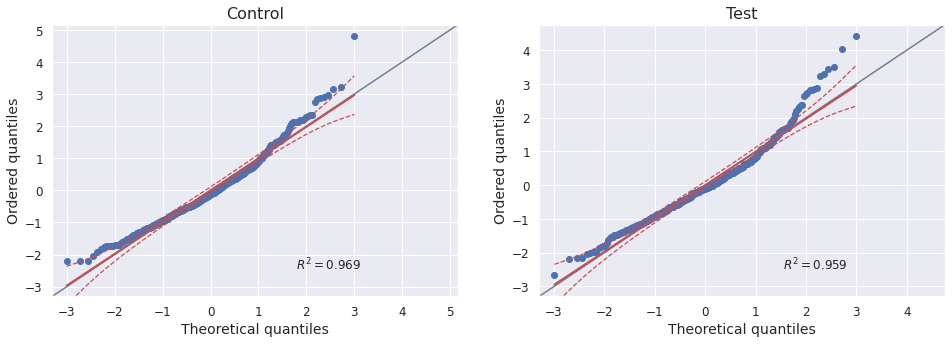

In [33]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
samples      = [control_aov, test_aov]
titles       = ['Control', 'Test']

for ax, sample, title in zip(axes.flatten(), samples, titles):
    pg.qqplot(sample, ax = ax)
    ax.set_title(title)

#### 2.6 Статистические критерии

- Шапиро-Уилка (для выборок < 1000)
- Харке-Бера
- Д'агостино (Normal Test)

In [34]:
# проверка на нормальность критерием Шапиро-Уилка

shapiro = {
    'control_p' : stats.shapiro(control_aov)[1],
    'test_p'    : stats.shapiro(test_aov)[1]
}

print('Контрольное распределение: {}'.format('ненормальное' if shapiro['control_p'] < 0.05 else 'нормальное'))
print('Тестовое распределение: {}'.format('ненормальное' if shapiro['test_p'] < 0.05 else 'нормальное'))

Контрольное распределение: ненормальное
Тестовое распределение: ненормальное


Статистические критерии и qq-plots говорят нам о том, что есть все основания отклонить нулевую гипотезу о том, что выборочные данные нормально распределены. Следовательно, есть несколько вариантов для дальнейшего анализа

- Преобразование данных логарифмированием или методом Бокса-Кокса
- Использование непараметрического критерия Манна-Уитни
- Использование T-Test (выборка > 100)

Будем использовать вариант с T-Test, так как это распространенная практика - использовать данный тест на больших выборках даже при ненормальном распределении. Однако, необходимо проверить дисперсии в данных, чтобы определиться будем ли мы использовать оригинальный T-Test или модификацию Уэлча. Проверку на гомогенность будем осуществлять с помощью теста Левена, так как он более робастный к отклонениям от симметрии нежели тест Бартлетта

In [35]:
# проверка на гомоскедастичность тестом Левена

stats.levene(control_aov, test_aov)

LeveneResult(statistic=22.49207791053141, pvalue=2.41166329867886e-06)

Проверка на гомоскедастичность критерием Левена показала, что у нас достаточно оснований отклонить нулевую гипотезу о равенстве дисперсий 2-х выборок. Соответственно, для сравнения средних в 2-х выборках будем использовать модифицированный t-критерий Уэлча для выборок с разными дисперсиями

#### 2.7 Проверка гипотезы о равенстве средних чеков в 2-х группах

In [36]:
# тест Уэлча для выборок с неоднородными дисперсиями

stats.ttest_ind(control_aov, test_aov, equal_var = False)

Ttest_indResult(statistic=1.2605219927635725, pvalue=0.2077822112341301)

In [37]:
# U-критерий Манна-Уитни

stats.mannwhitneyu(control_aov, test_aov)

MannwhitneyuResult(statistic=132447.5, pvalue=0.49684884726587475)

Данный критерий также говорит о том, что нет оснований утверждать, что выборки имеются статистически значимые различия. Однако мы знаем, что вероятность совершить ошибку II рода в данном случае для размера эффекта, равного 0.08, составляет порядка 75% (1 - мощность теста). То есть мы с большой долей вероятности просто могли не найти статистически значимые различия между средними значениями пользовательских чеков, даже если они и правда есть. **Поэтому к результатам расчета данного показателя, стоит относится с недоверием**

Можно предположить, что **средний чек пользователя в 2-х группах и правда не отличается друг от друга**. Тогда мы знаем, что **количество покупок на пользователя в тестовой группе преобладает**, и следовательно средняя прибыль с пользователя должна в тестовой группе также быть выше. Давайте проверим эту гипотезу!

<img src = 'https://gifdb.com/images/high/let-s-go-let-s-do-this-dwight-schrute-781hy0bq8jb4kr64.gif'>


## 3. Прибыль с пользователя

In [38]:
# подготовка данных для анализа прибыли с пользователя

revenue_per_user = data \
    .pivot_table(
        values     = 'price',
        index      = ['user_id', 'order_id', 'group'],
        columns    = 'action',
        aggfunc    = 'sum',
        fill_value = 0
    ) \
    .reset_index()

revenue_per_user = revenue_per_user \
    .assign(total_revenue = revenue_per_user.create_order - revenue_per_user.cancel_order) \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'total_revenue' : 'sum'}) 

In [39]:
# выборки

control_revenue = revenue_per_user.loc[revenue_per_user.group == 0].total_revenue
test_revenue    = revenue_per_user.loc[revenue_per_user.group == 1].total_revenue

И снова тот же алгоритм, что и для анализа предыдущих метрик. Сперва посмотрим на распределения, затем на гомогенность дисперсий, выберем критерий и сравним 2 метрики друг с другом. 

#### 3.1 Гистограммы распределения 

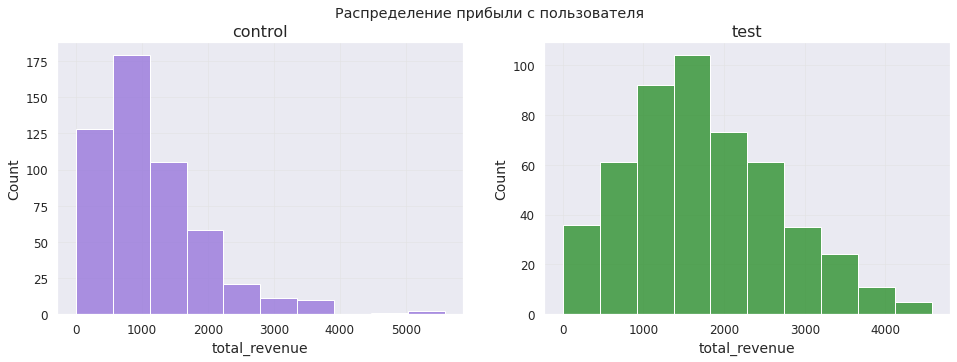

In [40]:
# построение гистограмм распределения

draw_histplot([control_revenue, test_revenue], 'Распределение прибыли с пользователя')

#### 3.2 Описательные статистики

In [41]:
# описательные статистики для контрольной выборки 

show_statistics(control_revenue)

{'mean': 1132.9240776699028,
 'median': 951.1999999999999,
 'std': 812.0949213526965,
 'skew': 1.533949433195731,
 'kurtosis': 3.690709473664561}

In [42]:
# описательные статистики для тестовой выборки 

show_statistics(test_revenue)

{'mean': 1750.25577689243,
 'median': 1628.8999999999999,
 'std': 931.1293648512636,
 'skew': 0.5136119529003585,
 'kurtosis': -0.1707536678299859}

Снова проверяем размер полученного эффекта и сравниваем его с MDE для используемых параметров

#### 3.4 Lift

In [43]:
# расчет изменения метрики в тестовой группе относительно контрольной группы

lift = (test_revenue.mean() / control_revenue.mean()) - 1
print('Lift составил {}%'.format(round(lift * 100, 2)))

Lift составил 54.49%


#### 3.5 Effect Size

In [44]:
# расчет стандартизированного размера эффекта 

# выборочные дисперсии
control_var = control_revenue.var()
test_var    = test_revenue.var()

# общая дисперсия для 2-х групп
pooled_var  = calc_pooled_var(control_var, test_var, nobs1, nobs2)

# расчет эффекта 
effect_size = (test_revenue.mean() - control_revenue.mean()) / pooled_var

print('Стандартизированный размер эффекта, выявленный в результате эксперимента: {}'.format(round(effect_size, 2)))

Стандартизированный размер эффекта, выявленный в результате эксперимента: 0.71


Согласно шкале интерпретации эффекта Коэна - это довольно-таки большой эффект. Сравнивая его с MDE (0.175) можем заключить, что вероятность обнаружения такого эфффекта довольно-таки высокая, а значит мы можем доверять результатам нашего AB-тестирования

#### 3.3 QQ-Plots

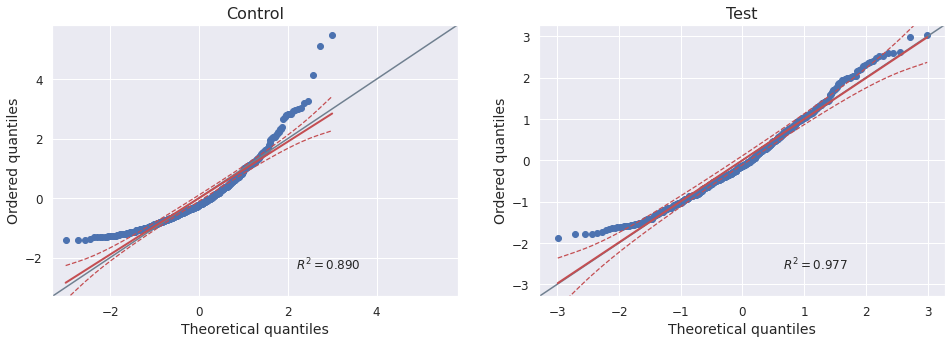

In [45]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 5))
samples      = [control_revenue, test_revenue]
titles       = ['Control', 'Test']

for ax, sample, title in zip(axes.flatten(), samples, titles):
    pg.qqplot(sample, ax = ax)
    ax.set_title(title)

#### 3.4 Статистические критерии

- Шапиро-Уилка (для выборок < 1000)
- Харке-Бера
- Д'агостино (Normal Test)

In [46]:
# проверка на нормальность критерием Шапиро-Уилка

shapiro = {
    'control_p' : stats.shapiro(control_revenue)[1],
    'test_p'    : stats.shapiro(test_revenue)[1]
}

print('Контрольное распределение: {}'.format('ненормальное' if shapiro['control_p'] < 0.05 else 'нормальное'))
print('Тестовое распределение: {}'.format('ненормальное' if shapiro['test_p'] < 0.05 else 'нормальное'))

Контрольное распределение: ненормальное
Тестовое распределение: ненормальное


Статистические критерии и qq-plots снова говорят нам о том, что есть все основания отклонить нулевую гипотезу о том, что выборочные данные нормально распределены. Следовательно, посмотрим на наличие гомоскедастичности в данных и дальше выберем между Стъюдентом и Уэлчем

In [47]:
# проверка на гомоскедастичность тестом Левена

stats.levene(control_revenue, test_revenue)

LeveneResult(statistic=18.4065054293346, pvalue=1.9550073151277537e-05)

Проверка на нормальность и гомоскедастичность наших выборочных данных показала, что данные распределены ненормально и дисперсии между выборками статистически значимо различаются. Следовательно для оценки среднего используем модификацию T-Теста Уэлча

#### 3.5 Проверка гипотезы о равенстве прибыли с пользователя в 2-х группах

In [48]:
# тест Уэлча для выборок с неоднородными дисперсиями

stats.ttest_ind(control_revenue, test_revenue, equal_var = False)

Ttest_indResult(statistic=-11.256494700536772, pvalue=9.627796378033664e-28)

Проверка показала, что средние значения прибыли в контрольной и тестовой группе статистически значимо различаются. Можно сделать вывод, что прибыль и правда выросла за счет того, что люди стали совершать больше покупок, а не за счет покупок более дорогих товаров. 

<img src = 'https://imgflip.com/s/meme/Money-Money.jpg'>


## Выводы

На основе полученных результатов, можно сделать следующий вывод. Анализ показал, что в тестовой группе пользователи делают больше заказов, нежели в контрольной группе. При этом также было доказано, что данное отклонение количества покупок в тестовой группе от такой же метрики в контрольной группе, можно обнаружить с довольно-таки большой вероятностью. 

Однако, при проверке различий между величиной среднего чека в тестовой и контрольной группах, было выяснено, что используемые параметры анализа (уровень значимости, мощность теста и размер выборки) не позволяет избежать значительной вероятноси ошибки II рода и не найти статистически значимые различия там, где они действительно есть. Критерий Стъюдента показал, что статистически значимых различий между 2-мя метриками нет, однако принимая во внимание размер MDE, вероятность ошибки очень велика. 


Далее, мы сделали предположение, что различий между средними чеками в 2-х группах правда может не быть, а так как количество покупок в тестовой группе увеличилось, что можно предположить, что вырастет и общая прибыль с пользователя. Сравнение средних значений в 2-х группах также подвердило эту гипотезу (effect_size < MDE, p_value <0.05)


Следовательно, пользователи в тестовой группе не просто покупают больше товаров, а еще и делают это по той же стоимости, что и пользователи в контрольной группе. В результате, это приносит платформе больше прибыли, что так же было статистически подтверждено. Поэтому можем сказать, что новая рекомендательная система очень полезна как для пользователя (теперь он чаще находит необходимые ему товары), так и для продукта (приносит ему дополнительную прибыль). **Можно провести еще одно тестирование, но с выборкой большего размера, и если результаты анализа также покажут, что различий между средними чеками в 2-х группах нет, то внедрять ее в production**